<a href="https://colab.research.google.com/github/denniesbor/spwio/blob/from_colab/notebooks/risk_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contextily
!pip install bezpy
# Install pySECS
!pip install pysecs

In [ ]:
# Install times roman fonts
!sudo apt-get install -y ttf-mscorefonts-installer
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ttf-mscorefonts-installer is already the newest version (3.8ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/msttcorefonts: caching, new cache contents: 60 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local

In [ ]:
import random
import os
import json
import warnings
import logging
import csv
import tqdm
import time
import shutil
import string
import math
import gc
import json
from itertools import combinations, product, islice
from multiprocessing import Pool, Lock, cpu_count
import datetime
from joblib import dump, load
import pprint
import pickle
import bezpy
from pysecs import SECS

import pandas as pd
import numpy as np
import xarray as xr
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.font_manager as fm
import contextily as ctx

# Rebuild the font cache
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# prompt: suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the working directory
working_dir = "/content/drive/MyDrive/Phys575"
data_path = os.path.join(working_dir, "Data")

### Read the grid regions data

In [ ]:
# Import the grid region polygons
ferc_gdf = gpd.read_file(os.path.join(data_path, "nerc_gdf.geojson"))
# Transform to Web Mercator
ferc_gdf = ferc_gdf.to_crs(epsg=3857)
ferc_gdf.head(8)

REGION_ID                  REGIONS  \
0          1   WestConnectNonEnrolled   
1          2   WestConnectNonEnrolled   
2          3   WestConnectNonEnrolled   
3          4   WestConnectNonEnrolled   
4          5              WestConnect   
5          6              WestConnect   
6          7  NorthernGridUnconnected   
7          8    NorthernGridConnected   

                                            geometry  
0  POLYGON ((-12761279.606 4323176.969, -12761279...  
1  POLYGON ((-12443802.462 4033185.134, -12443802...  
2  POLYGON ((-12443404.821 4477333.005, -12443404...  
3  POLYGON ((-12041480.109 4925600.952, -12041479...  
4  POLYGON ((-12078649.778 4898500.249, -12078650...  
5  POLYGON ((-12885402.874 4034247.475, -12885401...  
6  POLYGON ((-13884814.234 6176874.986, -13884814...  
7  POLYGON ((-13826736.379 5169682.345, -13826736...

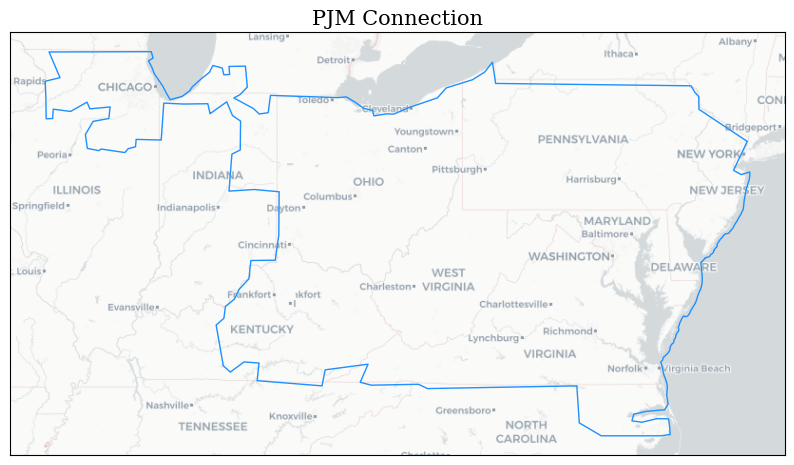

In [ ]:
# Subset PJM only
pjm_gdf = ferc_gdf[ferc_gdf["REGIONS"] == "PJM"]

# Plot PJM
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
pjm_gdf.plot(ax=ax, edgecolor='dodgerblue', facecolor='none')

# Set the Title
ax.set_title('PJM Connection', fontsize=15)
ax.grid(True)

# Adding the base map
ctx.add_basemap(ax, crs=pjm_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, attribution="")

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Load the US transmission data

In [ ]:
# US Transmission lines
trans_lines_gdf = gpd.read_file(os.path.join(data_path, "Electric__Power_Transmission_Lines/Electric__Power_Transmission_Lines.shp"))

# Retain initial crs
trans_lines_crs = trans_lines_gdf.crs

In [ ]:
# Translate MultiLineString to LineString geometries, taking only the first LineString
trans_lines_gdf.loc[
    trans_lines_gdf["geometry"].apply(lambda x: x.geom_type) == "MultiLineString", "geometry"
] = trans_lines_gdf.loc[
    trans_lines_gdf["geometry"].apply(lambda x: x.geom_type) == "MultiLineString", "geometry"
].apply(lambda x: list(x.geoms)[0])

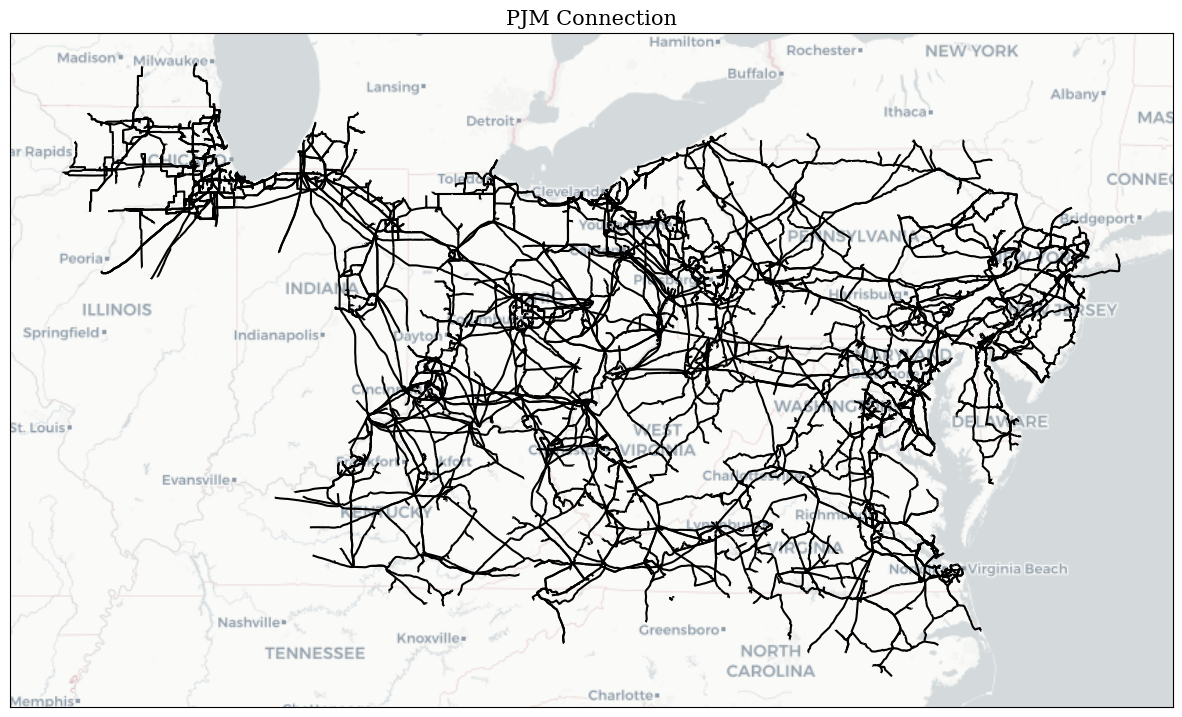

In [ ]:
# Get rid of erroneous 1MV and low power line voltages
trans_lines_gdf = trans_lines_gdf[(trans_lines_gdf["VOLTAGE"] >= 100)]

# Confine to PJM
trans_lines_gdf = trans_lines_gdf.to_crs(pjm_gdf.crs) # To same GDF
trans_lines_within_PJM = gpd.sjoin(trans_lines_gdf, pjm_gdf, how="inner", op='intersects') # Only those lines within PJM

# Plot the lines
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
trans_lines_within_PJM.plot(ax=ax, edgecolor='black')

# Set the Title
ax.set_title('PJM Connection', fontsize=15)
ax.grid(True)

# Adding the base map
ctx.add_basemap(ax, crs=trans_lines_within_PJM.crs.to_string(), source=ctx.providers.CartoDB.Positron, attribution="")

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Load the Transformer Data

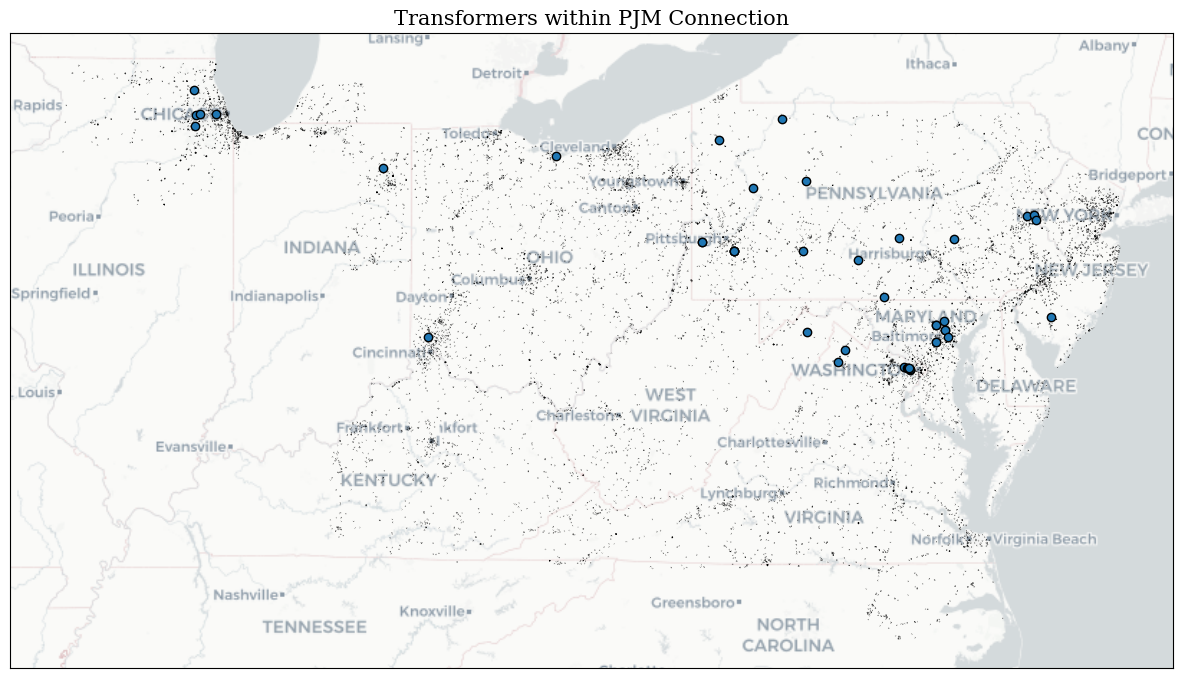

In [ ]:
# Load the US transformer data
ss_gdf = gpd.read_file(os.path.join(data_path, "substations.geojson"))

# Subset substations within PJM
# Check CRS and align if necessary
if ss_gdf.crs != pjm_gdf.crs:
    ss_gdf = ss_gdf.to_crs(pjm_gdf.crs)

# Do a spatial join
ss_within_PJM = gpd.sjoin(ss_gdf, pjm_gdf, how="inner", op='within')

# Plot the transformers
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ss_within_PJM.plot(ax=ax, edgecolor='black')

# Set the Title
ax.set_title('Transformers within PJM Connection', fontsize=15)
ax.grid(True)

# Adding the base map
ctx.add_basemap(ax, crs=ss_within_PJM.crs.to_string(), source=ctx.providers.CartoDB.Positron, attribution="")

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [ ]:
# Check the number of substations in PJM
print(ss_within_PJM.shape)

# Print current CRS of each GeoDataFrame
print("PJM_gdf CRS:", pjm_gdf.crs)
print("ss_within_PJM CRS:", ss_within_PJM.crs)
print("trans_lines_within_PJM CRS:", trans_lines_within_PJM.crs)

# Align CRS of ss_within_PJM and trans_lines_within_PJM to match pjm_gdf
ss_within_PJM = ss_within_PJM.to_crs(pjm_gdf.crs)
trans_lines_within_PJM = trans_lines_within_PJM.to_crs(pjm_gdf.crs)

# Get the substations that intersect with grid lines
if 'index_left' in ss_within_PJM.columns:
    ss_within_PJM.rename(columns={'index_left': 'index_left_old'}, inplace=True)
if 'index_right' in ss_within_PJM.columns:
    ss_within_PJM.rename(columns={'index_right': 'index_right_old'}, inplace=True)

if 'index_left' in trans_lines_within_PJM.columns:
    trans_lines_within_PJM.rename(columns={'index_left': 'index_left_old'}, inplace=True)
if 'index_right' in trans_lines_within_PJM.columns:
    trans_lines_within_PJM.rename(columns={'index_right': 'index_right_old'}, inplace=True)

# Only keep the polygon shapefile
ss_within_PJM = ss_within_PJM[ss_within_PJM.geom_type == 'Polygon']

# Perform spatial join to find intersections
intersections = gpd.sjoin(ss_within_PJM, trans_lines_within_PJM, how='inner', op='intersects')

(10153, 12)
PJM_gdf CRS: EPSG:3857
ss_within_PJM CRS: EPSG:3857
trans_lines_within_PJM CRS: EPSG:3857


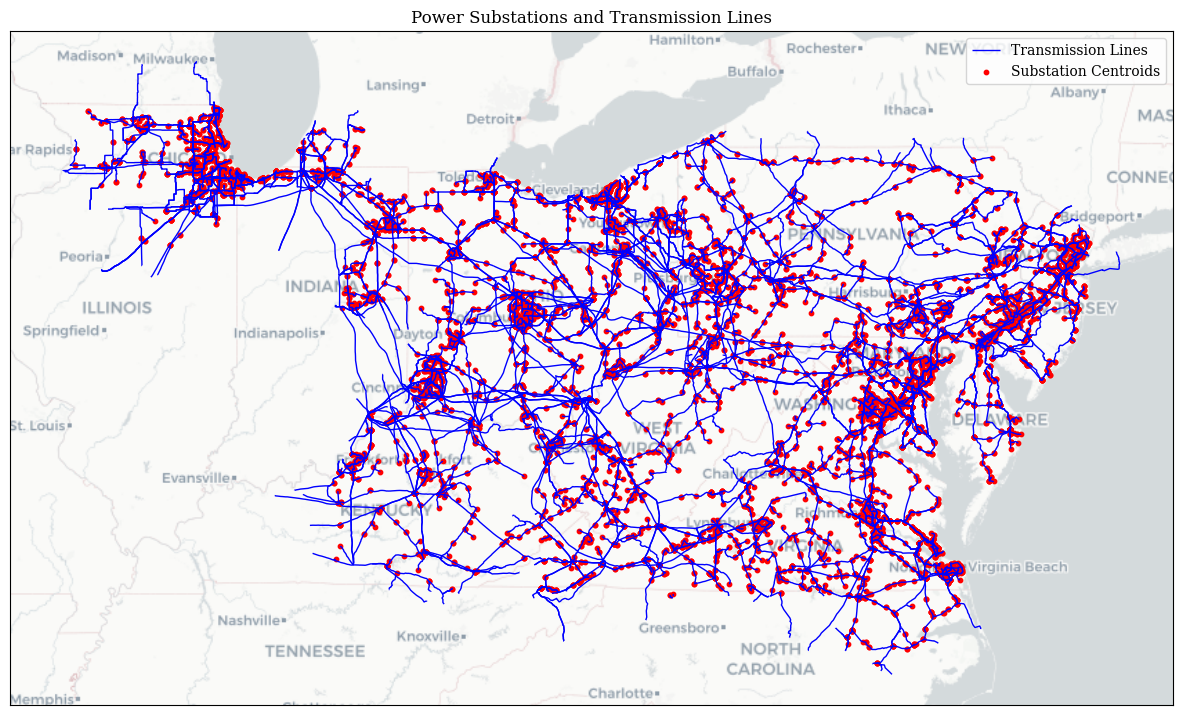

In [ ]:
intersections['centroid'] = intersections.geometry.representative_point()

# Create a new GeoDataFrame for centroids
centroids = gpd.GeoDataFrame(geometry=intersections['centroid'], crs=intersections.crs)

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))
trans_lines_within_PJM.plot(ax=ax, linewidth=1, color='blue', label='Transmission Lines')
# Adding the base map
ctx.add_basemap(ax, crs=ss_within_PJM.crs.to_string(), source=ctx.providers.CartoDB.Positron, attribution="")

centroids.plot(ax=ax, color='red', marker='o', label='Substation Centroids', markersize=10)

# Add legend and title
plt.legend()
plt.title('Power Substations and Transmission Lines')

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [ ]:
ss_within_PJM.geometry.head(4)

8274    POLYGON ((-8375923.936 4662250.093, -8375911.7...
8275    POLYGON ((-8375729.449 4662616.344, -8375729.3...
8276    POLYGON ((-8376078.826 4662360.388, -8376214.3...
8277    POLYGON ((-8368322.740 4655376.598, -8368307.3...
Name: geometry, dtype: geometry

### Magnetic Field Data

Will use Intermagnet file transfer server to access geomagnetic field from sites within Canada and the US. Due to the complexity of downloading historical data and for demonstration purposes, we have downloaded data recorded during the 2003 Halloween storm

In [ ]:
# Magnetic data dir
mag_data_folder = os.path.join(data_path, "2003")

# Function to convert HDZ to XYZ
def convert_hdz_to_xyz(df):
    # Convert declination from minutes to degrees
    df['D'] = df['D'] / 60
    # Convert degrees to radians
    df['D_rad'] = np.radians(df['D'])
    # Calculate X, Y, Z components
    df['X'] = df['H'] * np.cos(df['D_rad'])
    df['Y'] = df['H'] * np.sin(df['D_rad'])
    df['Z'] = df['Z']  # Z remains unchanged
    return df[['Timestamp', 'X', 'Y', 'Z']]

def process_magnetic_files(file_path):

  # Open the file and read the first lines to get metadata and header
  metadata_lines = []
  headers = []
  # Read the file
  with open(file_path, 'r') as file:
      files = file.readlines()
      start_data = 0
      start_comments = 0
      for i, line in enumerate(files):
        if line.startswith(" #") and start_comments == 0:
          metadata_lines = files[:i]
        if (line.startswith("DATE")):
          headers = line.split('|')
          headers = headers[0].split()
          headers = headers[:3] + [component[-1] for component in headers[3:]]
          start_data = i+1
          break

  # Metadata entries
  metadata_entries = [line.split('|')[0].strip() for line in metadata_lines]
  delimiter_length = len(metadata_entries[0]) - len(metadata_entries[0].split()[1])

  # Create dictionary
  metadata_dict = {}
  for entry in metadata_entries:
      key = entry[:delimiter_length].strip()
      value = entry[delimiter_length:].strip()
      metadata_dict[key] = value

  # Read the data, skipping the first 27 lines
  data = pd.read_csv(
      file_path,
      skiprows=start_data,
      delim_whitespace=True,
      names=headers,
      parse_dates={'Timestamp': ['DATE', 'TIME']}
  )

  #  Placeholders for bad data
  placeholders = [99999, 88888]

  # Check if the dataset has H, D, and Z columns
  if 'H' in data.columns and 'D' in data.columns and 'Z' in data.columns:
    # Replace with median in data
    for column in ['H', 'D', 'Z']:
      # Calculate the median for each column excluding the placeholders
      median_value = data[column].median()

      # Replace placeholders with the calculated median val
      data[column] = data[column].replace(placeholders, median_value)
    result = convert_hdz_to_xyz(data)
  else:
      if {'X', 'Y', 'Z'}.issubset(data.columns):
        result = data[['Timestamp', 'X', 'Y', 'Z']]
        # Replace with median in data
        for column in ['X', 'Y', 'Z']:
          # Calculate the median for each column excluding the placeholders
          median_value = result[column].median()

          # Replace placeholders with the calculated median val
          result[column] = result[column].replace(placeholders, median_value)

      else:
          print("Data columns are missing for either HDZ or XYZ format.")

  # Set the index to the timestamp
  result.set_index('Timestamp', inplace=True)

  # Convert the DataFrame to an xarray Dataset
  ds = xr.Dataset.from_dataframe(result)

  # Assign latitude and longitude as dataset attributes under the desired names
  ds.attrs['Latitude'] = float(metadata_dict['Geodetic Latitude'])
  ds.attrs['Longitude'] = float(metadata_dict['Geodetic Longitude']) - 360
  ds.attrs['Name'] = metadata_dict['IAGA Code']

  # Add metadata as global attributes to the dataset
  ds.attrs.update(metadata_dict)

  # Remove original keys / Eliminate duplication
  del ds.attrs['Geodetic Latitude']
  del ds.attrs['Geodetic Longitude']
  del ds.attrs['IAGA Code']

  return ds

In [ ]:
# List of valid observatories from Greg Lucas
usgs_obs = ['bou', 'brw', 'bsl', 'cmo', 'ded', 'dlr', 'frd', 'frn', 'gua', 'hon', 'new',
            'shu', 'sit', 'sjg', 'tuc']
nrcan_obs = ['blc', 'cbb', 'fcc', 'mea', 'ott', 'res', 'stj', 'vic', 'ykc']

In [ ]:
def process_directory(dir):
    print(f"Processing {dir}")
    datasets = []
    for filename in sorted(os.listdir(os.path.join(mag_data_folder, dir))):
        if filename.endswith('.min'):  # Filter for specific file type
            file_path = os.path.join(mag_data_folder, dir, filename)
            ds = process_magnetic_files(file_path)
            datasets.append(ds)
    if datasets:
        combined_dataset = xr.concat(datasets, dim='Timestamp')
        return (dir, combined_dataset)
    else:
        print(f"Missing datasets to combine in {dir}")
        return (dir, None)

observatory_dirs = [dir for dir in os.listdir(mag_data_folder) if dir.lower() in usgs_obs + nrcan_obs]
with Pool(processes=os.cpu_count()) as pool:
  results = pool.map(process_directory, observatory_dirs)

# Store results in dictionary
obsv_xarrays = {dir: dataset for dir, dataset in results if dataset is not None}

Processing GUAProcessing TUC

Processing NEWProcessing CMO

Processing VIC
Processing BSL
Processing BOU
Processing YKC
Processing FRD
Processing SIT
Processing STJ
Processing CBB
Processing DED
Processing FRN
Processing MEA
Processing FCC
Processing OTT
Processing RES
Processing HON
Processing SHU
Processing BRW
Processing DLR
Processing SJG
Processing BLC


In [ ]:
obs_xy = []
for name in obsv_xarrays:
    dataset = obsv_xarrays[name]
    obs_xy.append((dataset.Latitude, dataset.Longitude))

obs_xy = np.squeeze(np.array(obs_xy))

In [ ]:
# See if the fields fit
for name in usgs_obs + nrcan_obs:

    dataset = obsv_xarrays[name.upper()]
    distances = bezpy.tl.haversine_distance(lon1=dataset.Longitude, lat1=dataset.Latitude,
                                            lon2=obs_xy[:,1], lat2=obs_xy[:,0])

    datestring1 = '1985-01-01'
    if np.datetime64(datetime.datetime(1985, 1, 1)) < dataset.Timestamp[0].data:
        datestring1 = np.datetime_as_string(dataset.Timestamp[0].data)[:10]

    datestring2 = '2015-12-31'
    if np.datetime64(datetime.datetime(2015, 12, 31)) > dataset.Timestamp[-1].data:
        datestring2 = np.datetime_as_string(dataset.Timestamp[-1].data)[:10]

    print("  & {} & {:.2f} & {:.2f} & {:.2f} & {} & {} \\\\".format(name.upper(), dataset.Latitude, dataset.Longitude,
          np.min(distances[distances > 0]), datestring1, datestring2))

  & BOU & 40.14 & -105.24 & 1012.41 & 2003-10-27 & 2003-10-30 \\
  & BRW & 71.32 & -156.62 & 304.78 & 2003-10-27 & 2003-10-30 \\
  & BSL & 30.35 & -89.64 & 1090.47 & 2003-10-27 & 2003-10-30 \\
  & CMO & 64.87 & -147.86 & 611.60 & 2003-10-27 & 2003-10-30 \\
  & DED & 70.36 & -148.79 & 304.78 & 2003-10-27 & 2003-10-30 \\
  & DLR & 29.49 & -100.92 & 983.08 & 2003-10-27 & 2003-10-30 \\
  & FRD & 38.20 & -77.37 & 814.80 & 2003-10-27 & 2003-10-30 \\
  & FRN & 37.09 & -119.72 & 986.54 & 2003-10-27 & 2003-10-30 \\
  & GUA & 13.59 & -144.87 & 1635.24 & 2003-10-27 & 2003-10-30 \\
  & HON & 21.32 & -158.00 & 1635.24 & 2003-10-27 & 2003-10-30 \\
  & NEW & 48.27 & -117.12 & 465.68 & 2003-10-27 & 2003-10-30 \\
  & SHU & 55.35 & -160.46 & 1263.10 & 2003-10-27 & 2003-10-30 \\
  & SIT & 57.06 & -135.33 & 1096.55 & 2003-10-27 & 2003-10-30 \\
  & SJG & 18.11 & -66.15 & 2485.20 & 2003-10-27 & 2003-10-30 \\
  & TUC & 32.18 & -110.73 & 983.08 & 2003-10-27 & 2003-10-30 \\
  & BLC & 64.32 & -96.01 & 626.40 & 

In [ ]:
# Create a GDF of obsv locations
OBS_data = {
    'obsv_name': [name for name in obsv_xarrays],
    'geometry': [Point(obsv_xarrays[name].Longitude, obsv_xarrays[name].Latitude) for name in obsv_xarrays]
}

obsv_sites_gdf = gpd.GeoDataFrame(OBS_data, crs="EPSG:4326")

# Transform the site coordinates to match the PJM GDF CRS
obsv_sites_gdf = obsv_sites_gdf.to_crs(pjm_gdf.crs)

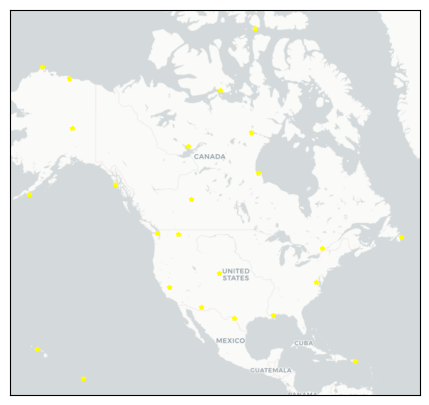

In [ ]:
# Plot the dist of obsv_sites
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

obsv_sites_gdf.plot(ax=ax, marker="*", color="yellow", markersize=10)
# Adding the base map
ctx.add_basemap(ax, crs=pjm_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, attribution="")

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [ ]:
# Get the observatories(y) within PJM
obsv_within_pjm = gpd.sjoin(obsv_sites_gdf, pjm_gdf, how='inner', op='intersects')

### Read EMTF Data Using Bezpy.
Gregs work is limited to USArray MT data. Will integrate with USMTArray

In [ ]:
# Set up logging
logging.basicConfig(filename='processed_files.log', level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')
def process_xml_file(full_path):
    try:
        site_name = os.path.basename(full_path).split('.')[1]
        site = bezpy.mt.read_xml(full_path)

        if site.rating < 3:
            print("Site rating is low")
            logging.info(f'Skipped: {full_path} (Outside region or low rating)')
            return None

        logging.info(f'Processed: {full_path}')
        return site
    except Exception as e:
        logging.error(f'Error processing {full_path}: {e}')
        return None

def process_sites(directory):
    MT_sites = []  # MT Sites objects
    completed = 0

    # Create a ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        # Future objects for each file processing task
        futures = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.xml'):
                    full_path = os.path.join(root, file)
                    futures.append(executor.submit(process_xml_file, full_path))

        # Collect results as they complete
        for future in as_completed(futures):
            result = future.result()
            if result:
                completed+=1
                MT_sites.append(result)

                if completed % 100 == 0:
                  print("Completed", completed)


    return MT_sites

In [ ]:
# EMTF data directory
emtf_data_dir = os.path.join(data_path, "EMTF")

# Pickle MT_sites path
mt_sites_pickle = os.path.join(emtf_data_dir, 'mt_pickle.pkl')

# Check pkl file of MT_sites
if os.path.exists(mt_sites_pickle):
  with open(mt_sites_pickle, 'rb') as pkl:
    MT_sites = pickle.load(pkl)

else:
  # Use threads to read and process the emtf files
  MT_sites= process_sites(emtf_data_dir)

Completed 100
Completed 200
Completed 300
Completed 400
Completed 500
Completed 600
Completed 700
Completed 800
Completed 900
Completed 1000
Completed 1100
Completed 1200
Completed 1300
Completed 1400
Completed 1500
Completed 1600


In [ ]:
# MT data into gdf
MT_data = {
    'site_id': [site.name for site in MT_sites],
    'geometry': [Point(site.longitude, site.latitude) for site in MT_sites]
}

mt_sites_gdf = gpd.GeoDataFrame(MT_data, crs="EPSG:4326")

# Transform the site coordinates to match the PJM GDF CRS
mt_sites_gdf = mt_sites_gdf.to_crs(pjm_gdf.crs)

# Perform spatial join
mt_within_pjm = gpd.sjoin(mt_sites_gdf, pjm_gdf, how="inner", op='intersects')

# Extract the indices of the sites that are within PJM
within_indices = mt_within_pjm.index.to_list()

# Filter MT_sites and site_xys based on the indices from within_pjm
filtered_MT_sites = [MT_sites[i] for i in within_indices]
filtered_site_xys = [(site.latitude, site.longitude) for site in  filtered_MT_sites]

filtered_site_xys = np.array(filtered_site_xys)

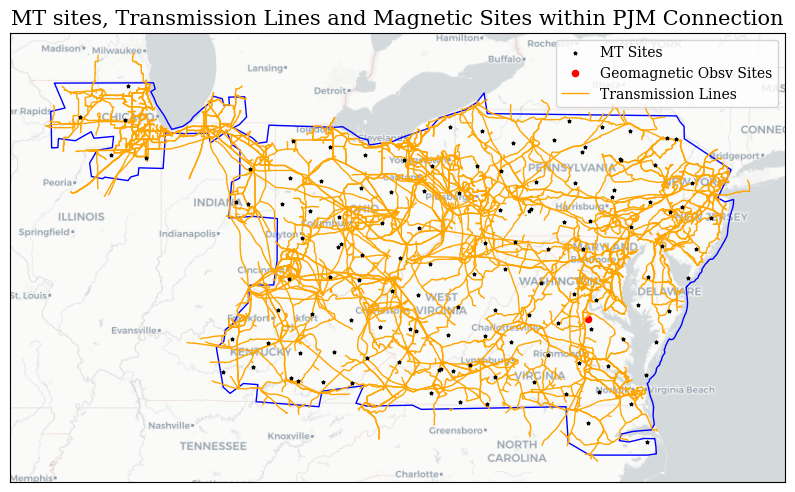

In [ ]:
# Plot the MT sites, transmission lines, and Geomagnetic observations within PJM

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
pjm_gdf.plot(ax=ax, edgecolor='blue', facecolor="none", label="PJM Interconnection", zorder=2)
mt_within_pjm.plot(ax=ax, color='black', marker='*', markersize=5, label ="MT Sites", zorder=3) # MT Sites
obsv_within_pjm.plot(ax=ax, color='red', marker='o', markersize=20, label ="Geomagnetic Obsv Sites", zorder=2) # MT Sites
trans_lines_within_PJM.plot(ax=ax, linewidth=1, color='orange', label='Transmission Lines') # Transmission lines

# Set the Title
ax.set_title('MT sites, Transmission Lines and Magnetic Sites within PJM Connection', fontsize=15)
ax.grid(True)

# Adding the base map
ctx.add_basemap(ax, crs=pjm_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, attribution="")

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])
plt.legend()

plt.show()

### Interpolate B and E-fields during Halloween Storm within MT Sites

This section leverages the Spherical Elementary Current system library developed by Greg Lucas

In [ ]:
halloween_start_time = datetime.datetime.utcfromtimestamp(obsv_xarrays["BOU"].Timestamp[0].data.astype('O')/1e9)
halloween_end_time = datetime.datetime.utcfromtimestamp(obsv_xarrays["BOU"].Timestamp[-1].data.astype('O')/1e9)

# Only load data that we need.
obs_xy = []
B_obs = []

B_frd = []

for name in obsv_xarrays:
    dataset = obsv_xarrays[name]

    data = dataset.loc[{'Timestamp': slice(halloween_start_time, halloween_end_time)}].interpolate_na('Timestamp')
    # No data here... skip ahead
    if len(data['Timestamp']) == 0:
        continue
    #data = data.apply(lambda x: bezpy.mag.filter(x, sample_freq=1./60, highcut=1./60, lowcut=1./(10000)))
    data = np.array(data.loc[{'Timestamp': slice(halloween_start_time, halloween_end_time)}].to_array().T)
    if np.any(np.isnan(data)):
        continue

    data = data - np.median(data, axis=0)
    obs_xy.append((dataset.Latitude, dataset.Longitude))
    B_obs.append(data)

obs_xy = np.squeeze(np.array(obs_xy))
B_obs = np.array(B_obs).swapaxes(0, 1)

In [ ]:
# Earth radius
R_earth = 6371e3

def calculate_SECS(B, obs_xy, pred_xy):
    """Calculate SECS output magnetic field

       B shape: (ntimes, nobs, 3 (xyz))

       obs_xy shape: (nobs, 2 (lat, lon))

       pred_xy shape: (npred, 2 (lat, lon))"""
    if obs_xy.shape[0] != B.shape[1]:
        raise ValueError("Number of observation points doesn't match B input")

    obs_lat_lon_r = np.zeros((len(obs_xy), 3))
    obs_lat_lon_r[:,0] = obs_xy[:,0]
    obs_lat_lon_r[:,1] = obs_xy[:,1]
    obs_lat_lon_r[:,2] = R_earth

    B_std = np.ones_like(B_obs)
    B_std[..., 2] = np.inf  # Ignoring Z component

    # specify the SECS grid
    lat, lon, r = np.meshgrid(np.linspace(15,85,36),
                              np.linspace(-175,-25,76),
                              R_earth+110000, indexing='ij')
    secs_lat_lon_r = np.hstack((lat.reshape(-1,1),
                                lon.reshape(-1,1),
                                r.reshape(-1,1)))

    secs = SECS(sec_df_loc=secs_lat_lon_r)

    secs.fit(obs_loc=obs_lat_lon_r, obs_B=B, obs_std=B_std, epsilon=0.05)

    # Create prediction points
    pred_lat_lon_r = np.zeros((len(pred_xy), 3))
    pred_lat_lon_r[:,0] = pred_xy[:,0]
    pred_lat_lon_r[:,1] = pred_xy[:,1]
    pred_lat_lon_r[:,2] = R_earth

    B_pred = secs.predict_B(pred_lat_lon_r)

    return B_pred

In [ ]:
# Predict the MT sites B and E fields
B_pred2 = calculate_SECS(B_obs, obs_xy, filtered_site_xys)
E_pred2 = np.zeros((len(B_obs), len(filtered_site_xys), 2))

for i, site in enumerate(filtered_MT_sites):
    Ex, Ey = site.convolve_fft(B_pred2[:,i,0], B_pred2[:,i,1], dt=60)
    E_pred2[:,i,0] = Ex
    E_pred2[:,i,1] = Ey

### Plot the DST indices of Boulder observatory

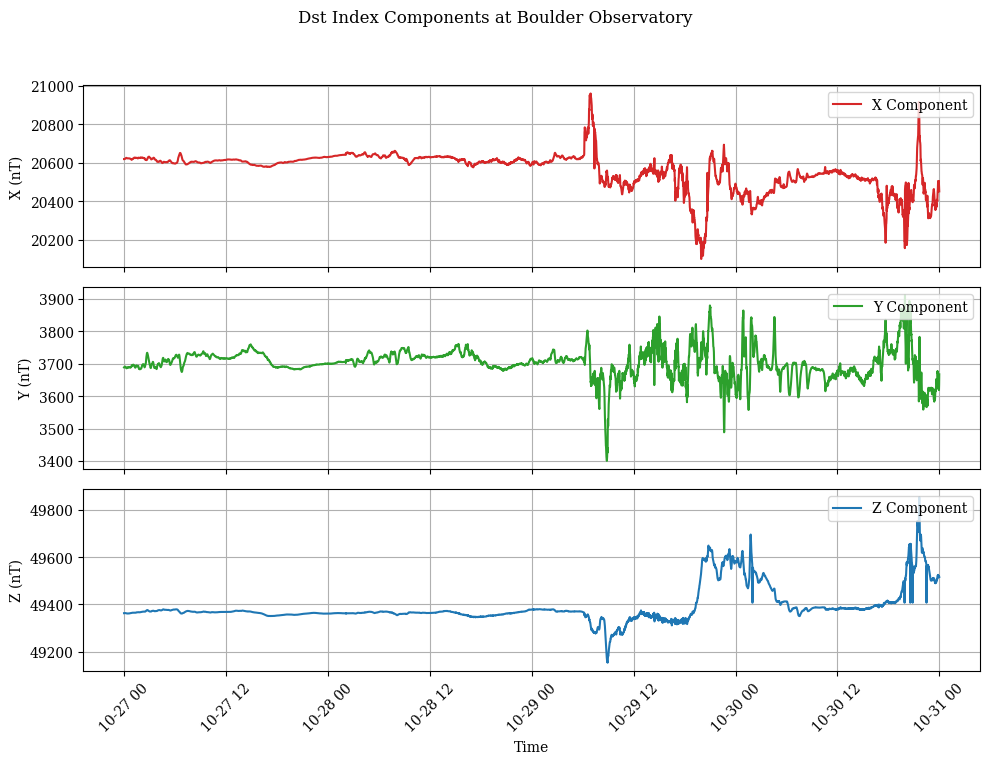

In [ ]:
boulder_xarr = obsv_xarrays["BOU"] # Boulder OBSV

# Example extraction from the xarray DataSet
X_component = boulder_xarr['X'].data
Y_component = boulder_xarr['Y'].data
Z_component = boulder_xarr['Z'].data
time_stamp = boulder_xarr['Timestamp'].data

# Create figure and axes
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)  # Share X axis for alignment

# Plot each component in a subplot
axs[0].plot(time_stamp, X_component, label='X Component', color='tab:red')
axs[0].set_ylabel('X (nT)')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].plot(time_stamp, Y_component, label='Y Component', color='tab:green')
axs[1].set_ylabel('Y (nT)')
axs[1].legend(loc='upper right')
axs[1].grid(True)

axs[2].plot(time_stamp, Z_component, label='Z Component', color='tab:blue')
axs[2].set_ylabel('Z (nT)')
axs[2].legend(loc='upper right')
axs[2].grid(True)

# Add a common X-axis label
axs[2].set_xlabel('Time')
axs[2].tick_params(axis='x', rotation=45)

# Add a title
fig.suptitle('Dst Index Components at Boulder Observatory')

# Tight layout to ensure there's no overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**There is only one observatory in PJM (FRD). Let's visualize the DST indices recorded during the storm and compare with pred vals of the neighboring MT sites**

In [ ]:
# Geomagnetic observatory within PJM
obsv_within_pjm

obsv_name                          geometry  index_right  REGION_ID REGIONS
10       FRD  POINT (-8612789.003 4607859.414)           19         20     PJM

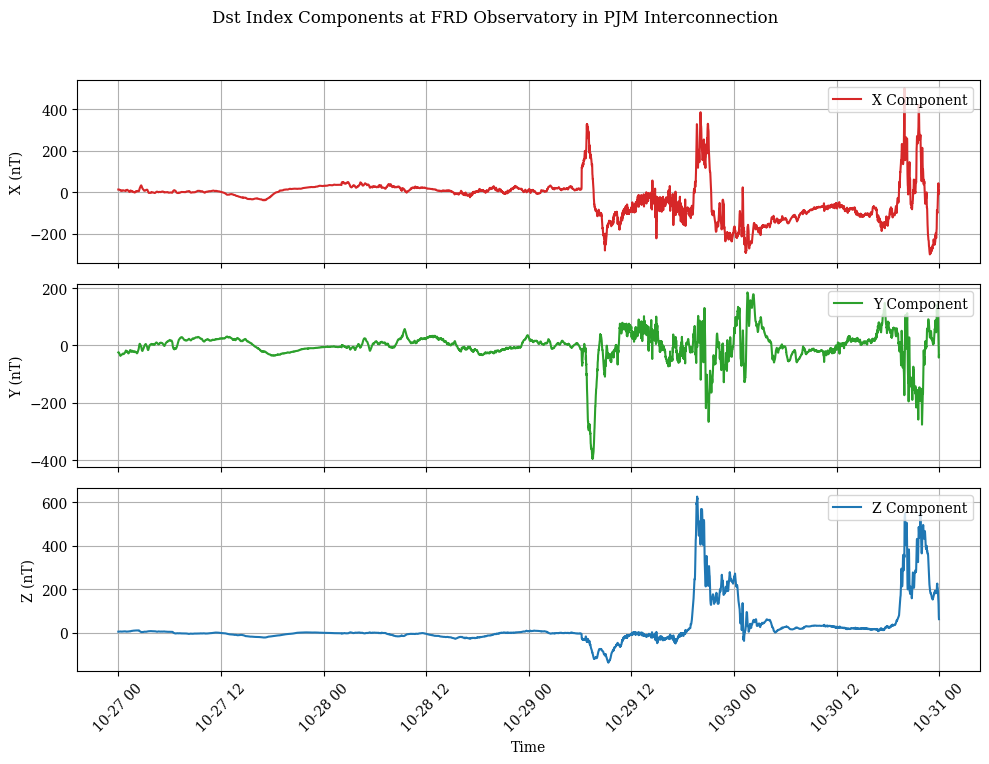

In [ ]:
frd_xarr = obsv_xarrays["FRD"] # Boulder OBSV

# De trend the data
mean_x = frd_xarr['X'].median()
mean_y = frd_xarr['Y'].median()
mean_z = frd_xarr['Z'].median()

# Example extraction from the xarray DataSet
X_component = frd_xarr['X'] - mean_x
Y_component = frd_xarr['Y'] - mean_y
Z_component = frd_xarr['Z'] - mean_z
time_stamp = frd_xarr['Timestamp'].data

# Create figure and axes
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)  # Share X axis for alignment

# Plot each component in a subplot
axs[0].plot(time_stamp, X_component, label='X Component', color='tab:red')
axs[0].set_ylabel('X (nT)')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].plot(time_stamp, Y_component, label='Y Component', color='tab:green')
axs[1].set_ylabel('Y (nT)')
axs[1].legend(loc='upper right')
axs[1].grid(True)

axs[2].plot(time_stamp, Z_component, label='Z Component', color='tab:blue')
axs[2].set_ylabel('Z (nT)')
axs[2].legend(loc='upper right')
axs[2].grid(True)

# Add a common X-axis label
axs[2].set_xlabel('Time')
axs[2].tick_params(axis='x', rotation=45)

# Add a title
fig.suptitle('Dst Index Components at FRD Observatory in PJM Interconnection')

# Tight layout to ensure there's no overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Let's find an MT site near the FRD obs and compare with the pred vals using SECs**

In [ ]:
# Location of FRD site in PJM
observation_point = obsv_within_pjm.geometry.iloc[0]

# Calculate distances from the observation site to each MT site
mt_within_pjm['distance'] = mt_within_pjm.geometry.distance(observation_point)

# Sort by distance and select the nearest 3 or 4 sites
nearest_sites = mt_within_pjm.sort_values(by='distance').head(4)  # Change to head(3) for 3 nearest sites

# Print the nearest MT sites
nearest_sites

site_id                          geometry  index_right  REGION_ID REGIONS  \
51    VAP58  POINT (-8603618.948 4580797.601)           19         20     PJM   
634   TTO58  POINT (-8591424.677 4658631.339)           19         20     PJM   
556   VAO57  POINT (-8648906.834 4673588.238)           19         20     PJM   
559   VAP57  POINT (-8690569.712 4595654.222)           19         20     PJM   

         distance  
51   28573.267313  
634  55083.779940  
556  74998.506801  
559  78732.492912

VAP58 is closest to the OBSV site

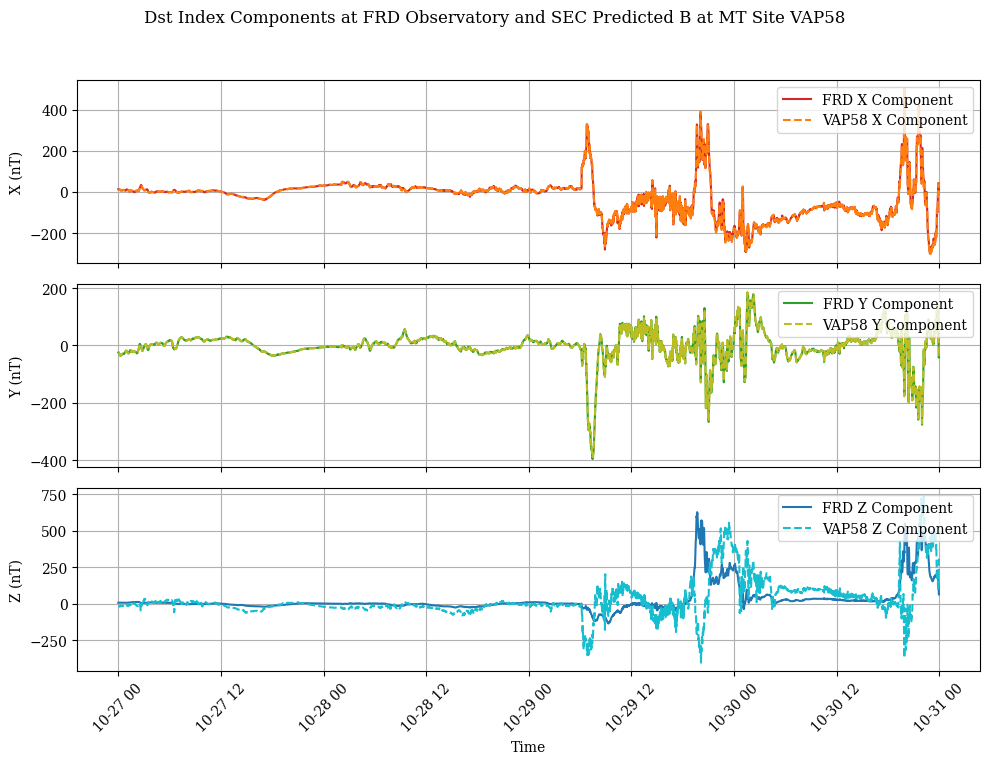

In [ ]:
site_names = [site.name for site in filtered_MT_sites]

# Get index and predicted B data of vap58
vap58_data = B_pred2[:, site_names.index('VAP58'), :]

# Overlay on top of the other one
mean_x = frd_xarr['X'].median()
mean_y = frd_xarr['Y'].median()
mean_z = frd_xarr['Z'].median()

X_component = frd_xarr['X'] - mean_x
Y_component = frd_xarr['Y'] - mean_y
Z_component = frd_xarr['Z'] - mean_z
time_frd = frd_xarr['Timestamp'].data  # Time for FRD data

# VAP58
time_vap58 = time_frd  # Time for VAP58 data
X_vap58 = vap58_data[:, 0]  # X component for VAP58
Y_vap58 = vap58_data[:, 1]  # Y component for VAP58
Z_vap58 = vap58_data[:, 2]  # Z component for VAP58

# Create figure and axes for the three subplots to show each component
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting FRD and VAP58 X components
axs[0].plot(time_frd, X_component, label='FRD X Component', color='tab:red')
axs[0].plot(time_vap58, X_vap58, label='VAP58 X Component', color='tab:orange', linestyle='--')
axs[0].set_ylabel('X (nT)')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plotting FRD and VAP58 Y components
axs[1].plot(time_frd, Y_component, label='FRD Y Component', color='tab:green')
axs[1].plot(time_vap58, Y_vap58, label='VAP58 Y Component', color='tab:olive', linestyle='--')
axs[1].set_ylabel('Y (nT)')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Plotting FRD and VAP58 Z components
axs[2].plot(time_frd, Z_component, label='FRD Z Component', color='tab:blue')
axs[2].plot(time_vap58, Z_vap58, label='VAP58 Z Component', color='tab:cyan', linestyle='--')
axs[2].set_ylabel('Z (nT)')
axs[2].legend(loc='upper right')
axs[2].grid(True)

# Set the common X-axis label
axs[2].set_xlabel('Time')
axs[2].tick_params(axis='x', rotation=45)

# Set the title of the figure
fig.suptitle('Dst Index Components at FRD Observatory and SEC Predicted B at MT Site VAP58')

# Ensure the layout is tight so that labels do not overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

### Plot the E-field as we

In [ ]:
# Get index and predicted B data of VAP58
VAP58_data = E_pred2[:, site_names.index('VAP58'), :]
# Get index and predicted B data of TTO58
TTO58_data = E_pred2[:, site_names.index('TTO58'), :]
# Get index and predicted B data of VAO57
VAO57_data = E_pred2[:, site_names.index('VAO57'), :]
# Get index and predicted B data of VAP57
VAP57_data = E_pred2[:, site_names.index('VAP57'), :]

# # Get the Ex and Ey of the sites
# VAP58
time_VAP58 = time_frd  # Time for VAP58 data
EX_VAP58 = VAP58_data[:, 0]  # X component for VAP58
EY_VAP58 = VAP58_data[:, 1]  # Y component for VAP58

# TTO58
time_TTO58 = time_frd  # Time for TTO58 data
EX_TTO58 = TTO58_data[:, 0]  # X component for TTO58
EY_TTO58 = TTO58_data[:, 1]  # Y component for TTO58

# VAO57
time_VAO57 = time_frd  # Time for VAO57 data
EX_VAO57 = VAO57_data[:, 0]  # X component for VAO57
EY_VAO57 = VAO57_data[:, 1]  # Y component for VAO57

# VAP58
time_VAP57 = time_frd  # Time for VAP57 data
EX_VAP57 = VAP57_data[:, 0]  # X component for VAP57
EY_VAP57 = VAP57_data[:, 1]  # Y component for VAP57

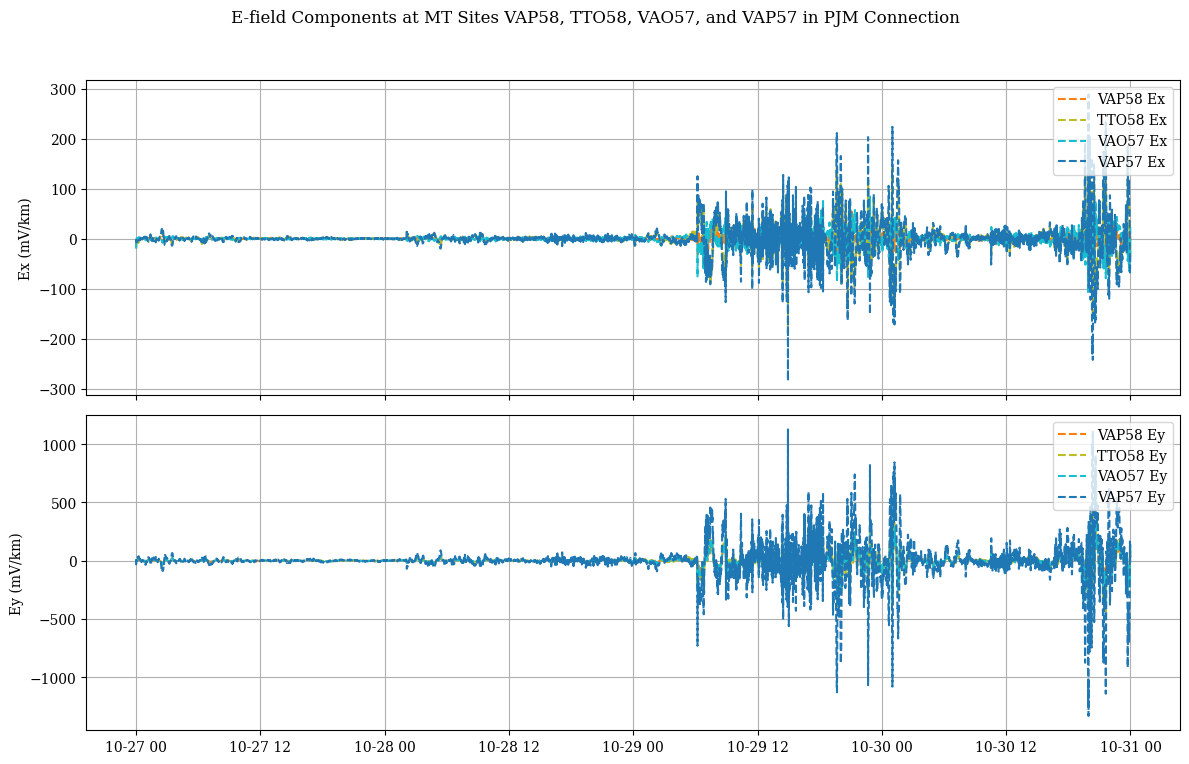

In [ ]:
# Create figure and axes for the three subplots to show each component
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plotting FRD and VAP58 X components
axs[0].plot(time_VAP58, EX_VAP58, label='VAP58 Ex', color='tab:orange', linestyle='--')
axs[0].plot(time_TTO58, EX_TTO58, label='TTO58 Ex', color='tab:olive', linestyle='--')
axs[0].plot(time_VAO57, EX_VAO57, label='VAO57 Ex', color='tab:cyan', linestyle='--')
axs[0].plot(time_VAP57, EX_VAP57, label='VAP57 Ex', color='tab:blue', linestyle='--')
axs[0].set_ylabel('Ex (mV/km)')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plotting FRD and VAP58 Y components
axs[1].plot(time_VAP58, EY_VAP58, label='VAP58 Ey', color='tab:orange', linestyle='--')
axs[1].plot(time_TTO58, EY_TTO58, label='TTO58 Ey', color='tab:olive', linestyle='--')
axs[1].plot(time_VAO57, EY_VAO57, label='VAO57 Ey', color='tab:cyan', linestyle='--')
axs[1].plot(time_VAP57, EY_VAP57, label='VAP57 Ey', color='tab:blue', linestyle='--')
axs[1].set_ylabel('Ey (mV/km)')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Set the title of the figure
fig.suptitle('E-field Components at MT Sites VAP58, TTO58, VAO57, and VAP57 in PJM Connection')

# Ensure the layout is tight so that labels do not overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


### Plot of E-field distribution within PJM MT sites

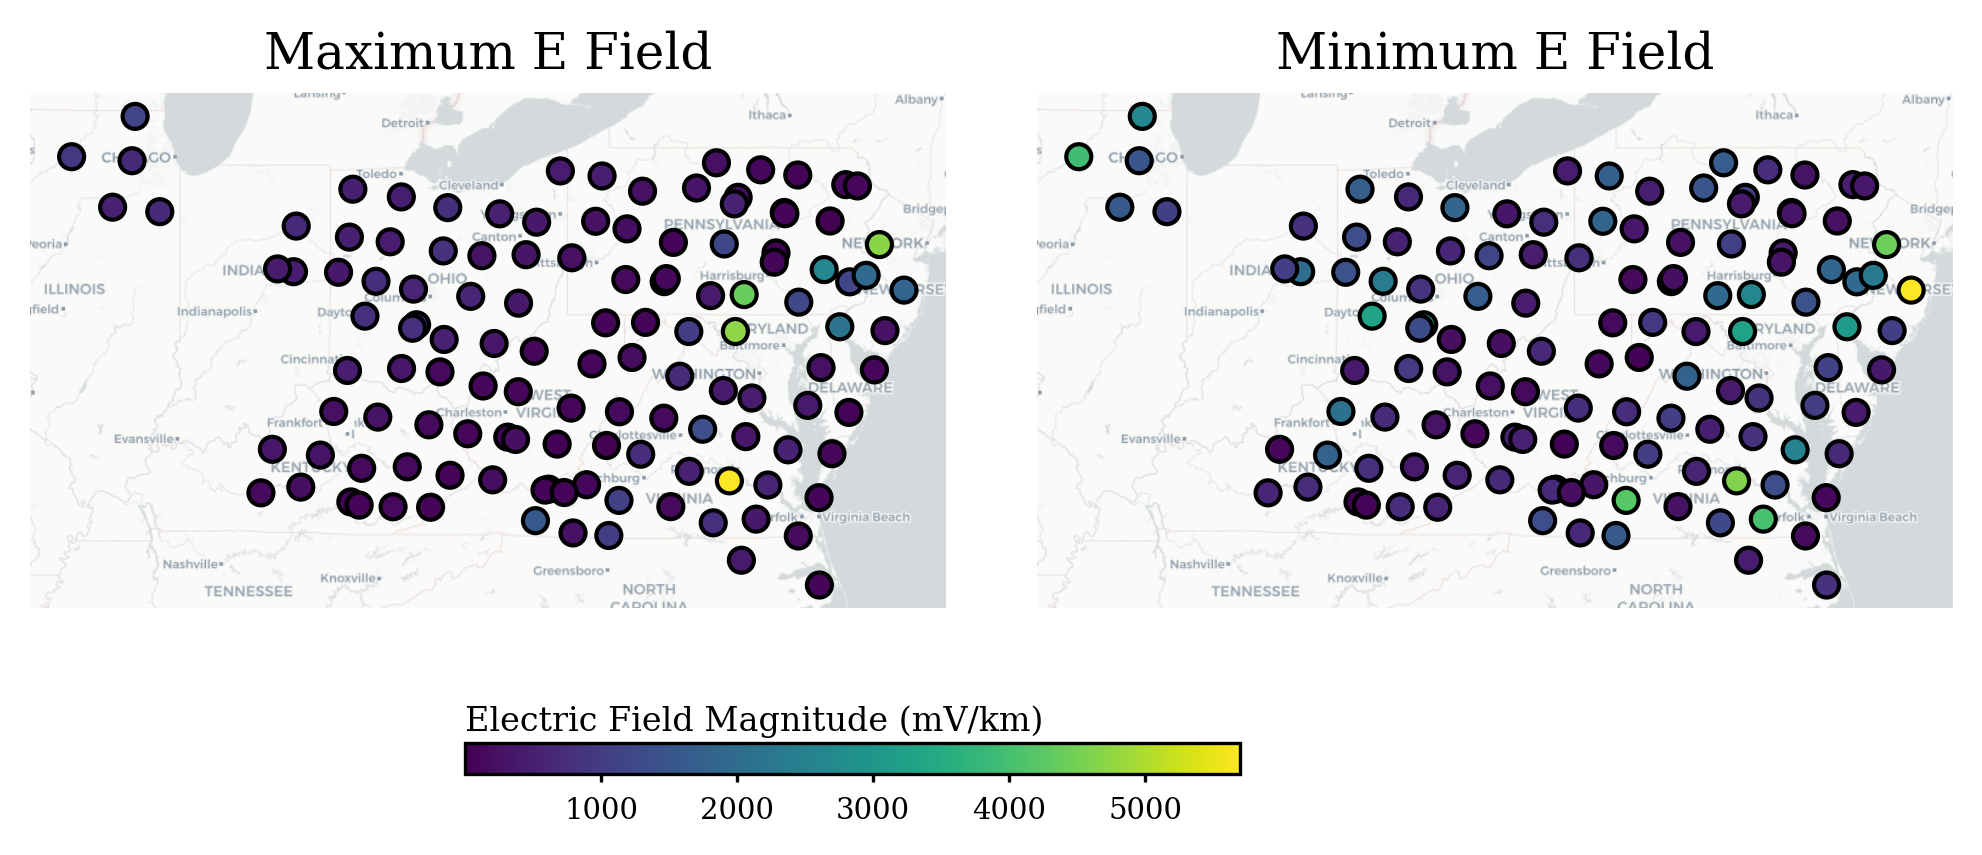

In [ ]:
# Loop through the E_preds and append to mt_within_pjm
E_max_vals = np.zeros(E_pred2.shape[1])
E_min_vals = np.zeros(E_pred2.shape[1])


for site_index in range(E_pred2.shape[1]):
    # Calculate the magnitude of E field for the site across all time points
    E = np.sqrt(E_pred2[:, site_index, 0]**2 + E_pred2[:, site_index, 1]**2)

    # Assign max and min to the corresponding arrays
    E_max_vals[site_index] = np.max(E)
    E_min_vals[site_index] = np.min(E)

# Assign calculated max and min values to the DataFrame
mt_within_pjm["E_min"] = E_min_vals
mt_within_pjm["E_max"] = E_max_vals

# Plot the E max and E min fields within PJM MT sites
fig = plt.figure(figsize=(8.27, 8.27), dpi=300)
gs = gridspec.GridSpec(1, 2, hspace=0.45, wspace=0.1)  # One row, two columns

# Define the color map
cmap = plt.get_cmap('viridis')
cmap.set_under('#cccccc')  # Set under-color for out-of-range low values
norm = colors.Normalize(vmin=np.min(E_min_vals), vmax=np.max(E_max_vals))

# Plot E_max
ax1 = fig.add_subplot(gs[0, 0])
mt_within_pjm.plot(ax=ax1, column='E_max', cmap=cmap, edgecolor='k')
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, attribution="")
ax1.set_title('Maximum E Field')
ax1.axis('off')  # Optional: Turn off the axis

# Plot E_min
ax2 = fig.add_subplot(gs[0, 1])
mt_within_pjm.plot(ax=ax2, column='E_min', cmap=cmap, edgecolor='k')
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, attribution="")
ax2.set_title('Minimum E Field')
ax2.axis('off')  # Optional: Turn off the axis

# Adding a colorbar manually if needed
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbaxes = inset_axes(ax1, width="100%", height="7%",
                    bbox_to_anchor=(0.8, 0.7, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)
cbar = plt.colorbar(sm, cax=cbaxes, orientation='horizontal')
cbar.ax.set_title("Electric Field Magnitude (mV/km)", fontsize=8, pad=3, loc='left')
cbar.ax.tick_params(labelsize=7, length=2)
ax1.grid(True, linestyle='-', linewidth=0.7, color='#FFFFFF')
ax1.set_facecolor('#f2f2f2')  # Set the plot background to grey
ax1.axis("off")  # Ensure axis is on to show the grid

# Show the plot
plt.show()

### Calculate voltage within the transmission lines
We also leverage Bezpy and Greg Lucas method to interpolate E fields onto trnamssion lines ans approximate voltage with

 $V = E.\delta l$

In [ ]:
# Set a copy MT sites within PJM
tl_gdf = trans_lines_within_PJM.copy()
tl_gdf = tl_gdf.to_crs(epsg=4326)

# Use Bezpy to get the transmission line length
tl_gdf["obj"] = tl_gdf.apply(bezpy.tl.TransmissionLine, axis=1)
tl_gdf["length"] = tl_gdf.obj.apply(lambda x: x.length)

# Use Delaunay triangulation to set weights
t1 = time.time()

tl_gdf.obj.apply(lambda x: x.set_delaunay_weights(filtered_site_xys))
print("Done filling interpolation weights: {0} s".format(time.time()-t1))


# Remove lines with bad integration
E_test = np.ones((1, len(filtered_site_xys), 2))

arr_delaunay = np.zeros(shape=(1, len(tl_gdf)))
for i, tLine in enumerate(tl_gdf.obj):
    arr_delaunay[:,i] = tLine.calc_voltages(E_test, how='delaunay')

# Filter the tl_gdf
tl_gdf_not_na = tl_gdf[~np.isnan(arr_delaunay[0, :])]

Done filling interpolation weights: 28.903064966201782 s


In [ ]:
# Calculate voltages

# Number of transmission lines
n_trans_lines = len(tl_gdf_not_na)
mag_times = pd.date_range(start=halloween_start_time, end=halloween_end_time, freq='1Min')
n_times = len(mag_times)

models = {"MT": filtered_MT_sites}

t0 = time.time()
arr_delaunay = np.zeros(shape=(n_times, n_trans_lines))

for i, tLine in enumerate(tl_gdf_not_na.obj):
    if i % 1000 == 0:
        print(i, ':', time.time()-t0, 's')
    arr_delaunay[:,i] = tLine.calc_voltages(E_pred2, how='delaunay')

df_voltage_delaunay = pd.DataFrame(index=mag_times, columns=tl_gdf_not_na.ID, data=arr_delaunay)

print("Done with all calculations: {0} s".format(time.time()-t0))

0 : 0.0005950927734375 s
1000 : 22.190457582473755 s
2000 : 39.20487332344055 s
3000 : 60.6241238117218 s
4000 : 81.12669277191162 s
5000 : 100.67203736305237 s
6000 : 122.23059844970703 s
Done with all calculations: 140.00076842308044 s


In [ ]:
# Let's get the voltages flowing at the max E fields during the storm.
# Will leverage the MT sites close to FRD observatory to get peak E fields

def max_e_field_and_time(EX, EY, times):
    # Calculate the magnitude of the electric field
    E_magnitude = np.sqrt(EX**2 + EY**2)

    # Find the index of the maximum value in E_magnitude
    max_index = np.argmax(E_magnitude)

    # Get the maximum E field
    max_e_field = E_magnitude[max_index]

    # Get the corresponding time
    max_time = times[max_index]

    return max_e_field, max_time

# Calculate for each site
max_E_VAP58, time_max_E_VAP58 = max_e_field_and_time(EX_VAP58, EY_VAP58, time_VAP58)
max_E_TTO58, time_max_E_TTO58 = max_e_field_and_time(EX_TTO58, EY_TTO58, time_TTO58)
max_E_VAO57, time_max_E_VAO57 = max_e_field_and_time(EX_VAO57, EY_VAO57, time_VAO57)
max_E_VAP57, time_max_E_VAP57 = max_e_field_and_time(EX_VAP57, EY_VAP57, time_VAP57)

# Print the results
print("Max E for VAP58:", max_E_VAP58, "at time:", time_max_E_VAP58)
print("Max E for TTO58:", max_E_TTO58, "at time:", time_max_E_TTO58)
print("Max E for VAO57:", max_E_VAO57, "at time:", time_max_E_VAO57)
print("Max E for VAP57:", max_E_VAP57, "at time:", time_max_E_VAP57)

Max E for VAP58: 353.10030428610304 at time: 2003-10-30T19:57:00.000000000
Max E for TTO58: 456.77523709168327 at time: 2003-10-30T21:37:00.000000000
Max E for VAO57: 403.35468543366085 at time: 2003-10-30T21:37:00.000000000
Max E for VAP57: 1363.1866589794015 at time: 2003-10-30T19:57:00.000000000


In [ ]:
# Plot of the voltage

t = time_max_E_VAP57

df_voltage = df_voltage_delaunay
voltages = np.ma.masked_invalid(df_voltage.loc[t,:].abs())


line_resistivity = 0.99 # Set line resistivity to 0.9
line_E = voltages/(line_resistivity*tl_gdf_not_na['length'].values)

tl_gdf_not_na['voltage'] = voltages
tl_gdf_not_na['E_field'] = line_E

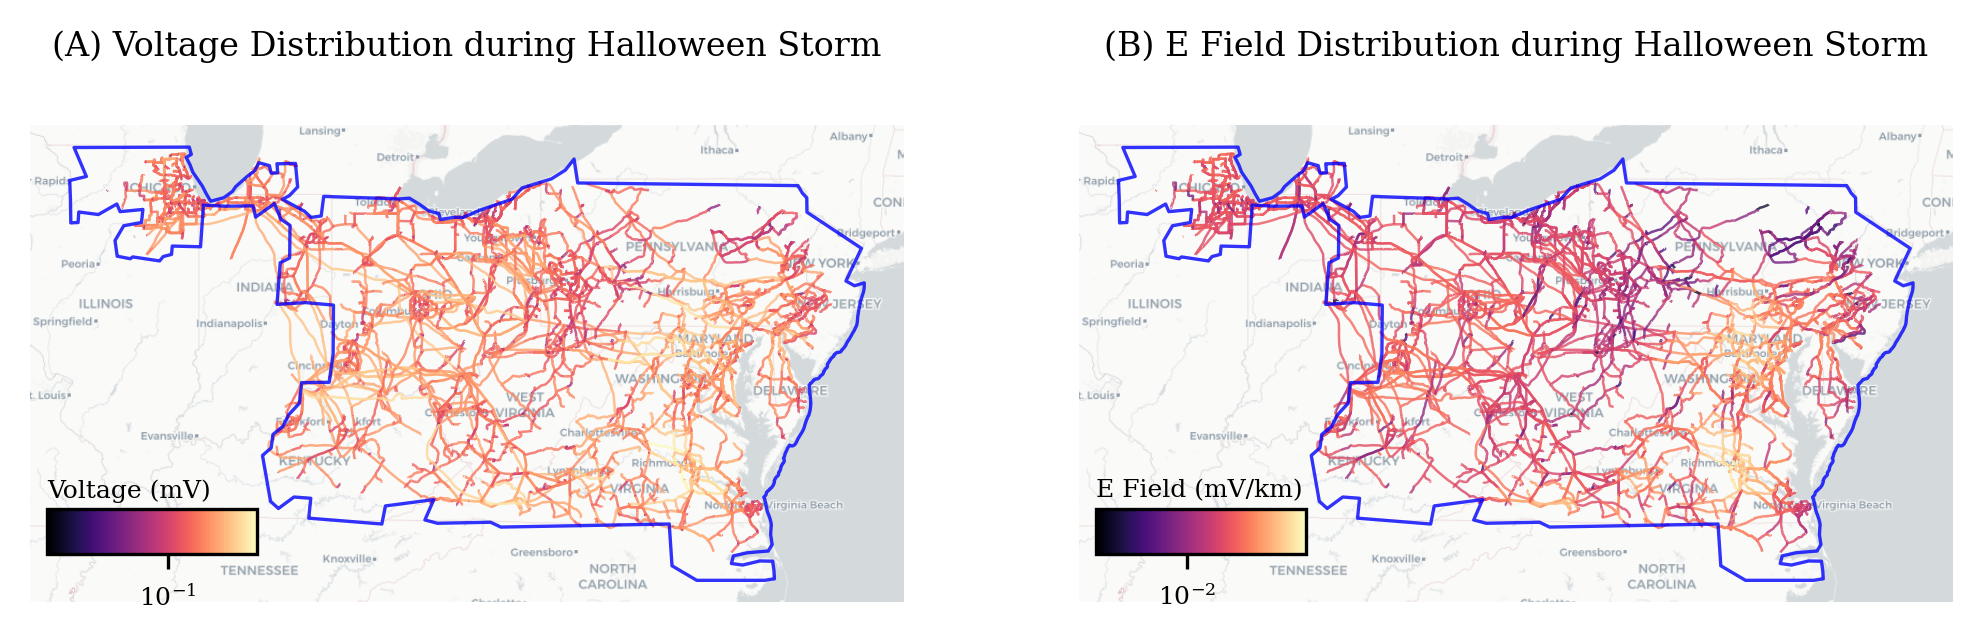

In [ ]:
# Convert back the crs of tl_gdf
tl_gdf_not_na = tl_gdf_not_na.to_crs(pjm_gdf.crs)

# Setup figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.27, 8.27), dpi=300)  # 1 row, 2 columns

# Adjust the colormap and the normalization
cmap = plt.cm.magma
vmin, vmax = np.min(tl_gdf_not_na["voltage"]), np.max(tl_gdf_not_na["voltage"])
normV = colors.LogNorm(vmin=vmin, vmax=vmax)
vmin, vmax = np.min(tl_gdf_not_na["E_field"]), np.max(tl_gdf_not_na["E_field"])
normE = colors.LogNorm(vmin=vmin, vmax=vmax)
cmap.set_under('#cccccc')  # Set under-color for out-of-range low values


tl_gdf_not_na.to_crs(epsg=3857).plot(ax=ax1, column='voltage', cmap=cmap, linewidth=0.6, norm=normV, alpha=0.8)
pjm_gdf.plot(ax=ax1, edgecolor='blue', facecolor="none", zorder=2, linewidth=0.8, alpha=0.8)
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, attribution="")
ax1.set_title('(A) Voltage Distribution during Halloween Storm', fontdict={'fontsize': 8})
ax_cbar = inset_axes(ax1,
                    width=0.7,
                    height=0.15,
                    loc='lower right',
                    bbox_to_anchor=(0.15, 0.1, 0.11, 0.09),
                    bbox_transform=ax1.transAxes,
                    borderpad=0)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=normV)
sm.set_array([])
cbar = plt.colorbar(sm, cax=ax_cbar, orientation='horizontal')
cbar.ax.set_title("Voltage (mV)", fontsize=6, pad=3, loc='left')
cbar.ax.tick_params(labelsize=6)
ax1.axis("off")

tl_gdf_not_na.to_crs(epsg=3857).plot(ax=ax2, column='E_field', cmap=cmap, linewidth=0.6, norm=normE, alpha=0.8)
pjm_gdf.plot(ax=ax2, edgecolor='blue', facecolor="none", zorder=2, linewidth=0.8, alpha=0.8)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, attribution="")
ax2.set_title('(B) E Field Distribution during Halloween Storm', fontdict={'fontsize': 8})
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normE)
ax_cbar_1 = inset_axes(ax2,
                    width=0.7,
                    height=0.15,
                    loc='lower right',
                    bbox_to_anchor=(0.15, 0.1, 0.11, 0.09),
                    bbox_transform=ax2.transAxes,
                    borderpad=0)
sm.set_array([])
cbar = plt.colorbar(sm, cax=ax_cbar_1, orientation='horizontal')
cbar.ax.set_title("E Field (mV/km)", fontsize=6, pad=3, loc='left')
cbar.ax.tick_params(labelsize=6)
ax2.axis('off')

# Show the plot
plt.subplots_adjust(top=0.85)
plt.show()